# Exploring the trade off between long and short term relief

Here we address two weaknesses of the formulations in our PSOR paper submission, namely: 

* shelter was allowed to be decommissioned faster than housing was built, effectively 'kicking people out' of shelter an into the unsheltered queue, and
* the crucial balance we look for (long-term relief via housing vs. short-term relief via shelter) was blurred in an objective function which penalised both the unsheltered queue and the sheltered queue. Penalising the sheltered queue was designed to prevent an over-reliance on shelter which would indicate a lack of long-term investment in housing which is where the real gains are to be made. 

We address the latter issue here by a) ensuring we model the system for long enough so that long-term relief via housing shows up in the unsheletered queue during the modeling horizon and (b) simplifying the objective function to only include the unsheletered queue at different times to more clearly balance long-term and short-term relief. We can control the sheltered queue appropriately using shape constraints. 

**What housing capacity do we ultimately need?**

We first use the arrival rate and the mean housing service time to calculate how many houses we need for a stable queueing system. We then suppose we have enough budget to reach this amount plus 10% (so the queue can actually decrease in the long run). We say we will build this capacity steadily over 5 years, and we won't build any extra shelters. Using similar data to before, we model this system for 10 years below using the fluid flow model. We keep a fairly low arrival rate so the capacity we need here is realistic given the costs/budget we used in the PSOR paper. 

In [1]:
import fluid_flow_model as fl
import matplotlib.pyplot as plt

In [2]:
capacity_buffer = 0.1 # how much more housing do we want eventually as proportion of what we need to reach steady state
building_horizon_years = 5
modeling_horizon_years = 10
arrival_rate_daily = 5
data_as_is = {'initial_capacity': {'housing': 4000, 'shelter': 1500},
 'initial_demand': 12000,
 'service_mean': {'housing': 5.0, 'shelter': 0.0},
              'arrival_rates': [arrival_rate_daily]*modeling_horizon_years}
capacity_required = (data_as_is['service_mean']['housing']*arrival_rate_daily*365)*(1+capacity_buffer)
capacity_got = data_as_is['initial_capacity']['housing']
solution = {'housing': [capacity_got + (capacity_required-capacity_got)*(i+1)*(1/building_horizon_years) for i in range(building_horizon_years)],
            'shelter': [1500]*building_horizon_years}
T_a = building_horizon_years*365 # building horizon (days)
T_b = (modeling_horizon_years - building_horizon_years)*365 # extra modelling horizon beyond building horizon (days)
c_s = 1/3 # cost of shelter relative to housing

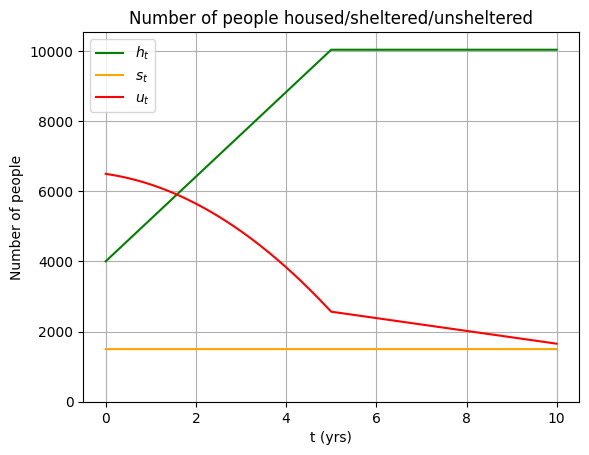

In [3]:
model = fl.FluidFlowModel(data_as_is, solution, T_a, T_b)
T = [i for i in range(T_a+T_b)]
model.analyse(T)
model.plot(T_a+T_b)

We now incrementally reduce the amount we spend on housing, spending instead what we can afford (with the reduction) on extra shelter in the first year. We dicate that we must decommission all this shelter and convert it into housing but we will not recover any money from that decomissioning. This conversion must happen steadilly from t=1 year to t=5 years (the end of the building horizon). Effectively this is saying that the act of building a shelter now and then converting it into a house is more expensive than simply building a house, but it buys us temporary relief to the unsheltered queue. 

As we reduce what we spend on housing, we see improvement to the unsheltered queue early on (because of the extra shelter) but worse conditions later (becuase of the lack of houses). We are looking this balance: how much long-term relief via housing should we sacrafice for early relief to the system via shelter. Clearly we want some level of early relief, but not so much that our long-term capacity is so unfavourable. 

The chart below illustrates this where the dark lines represent no sacrafice of housing, and as the lines get lighter, we sacrafice more houses to build shelter in the short-term. Notice that we never build so many shelters that the decommissioning would lead to the number of shelters dropping quicker than houses are built (addressing the initial point discussed above). 

In [5]:
u = []
s = []
h = []
labs = []
grads = []

n_options_xtra = 5 # scenarios to model beyond just above capacity buffer

for j in range(n_options_xtra+1):
    capacity_buffer_adapt = capacity_buffer * (1-(1/n_options_xtra)*j)
    capacity_required_adapt = (data_as_is['service_mean']['housing']*arrival_rate_daily*365)*(1+capacity_buffer_adapt)
    capacity_diff = capacity_required-capacity_required_adapt
    extra_shelter_afforded = (capacity_diff)/c_s
    solution_adapt = {'housing': [capacity_got + (capacity_required_adapt-capacity_got)*(i+1)*(1/building_horizon_years) for i in range(building_horizon_years)],
                      'shelter': [data_as_is['initial_capacity']['shelter'] + extra_shelter_afforded*(1-i/(building_horizon_years-1)) for i in range(building_horizon_years)]}
    model = fl.FluidFlowModel(data_as_is, solution_adapt, T_a, T_b)
    T = [i for i in range(T_a+T_b)]
    model.analyse(T)
    u.append(model.u)
    s.append(model.s)
    h.append(model.h)
    labs.append(str(int(capacity_diff)) + ' fewer houses')
    grads.append(((capacity_required_adapt-capacity_got)/building_horizon_years,extra_shelter_afforded/(building_horizon_years-1)))
    

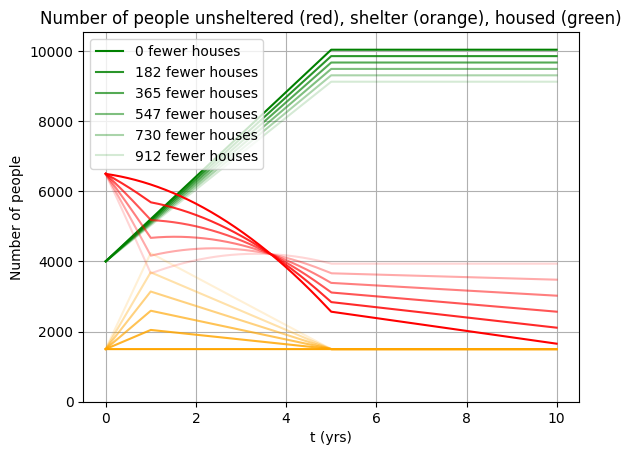

In [7]:
fig, ax = plt.subplots()
ymax = max(max(u)+max(s)+max(h))        

# plot solutions
x = [t/365 for t in range(T_a+T_b)]
for i in range(n_options_xtra+1):    
    ax.plot(x, h[i], color = 'green', alpha = 1-i/(n_options_xtra+1))
for i in range(n_options_xtra+1):
    ax.plot(x, u[i], color = 'red', alpha = 1-i/(n_options_xtra+1))
for i in range(n_options_xtra+1):
    ax.plot(x, s[i], color = 'orange', alpha = 1-i/(n_options_xtra+1))
ax.set(xlabel='t (yrs)', ylabel='Number of people',
       title='Number of people unsheltered (red), sheltered (orange), housed (green)')
ax.legend(labs, loc="upper left")
ax.grid()
ax.set_ylim(0,ymax*1.05)

# general
plt.show()


We now want an formulation which captures this trade off. 

\begin{align}
  y(\boldsymbol{h},\boldsymbol{s}) = \frac{1}{D} \sum_{d=1}^{D} u_d(\boldsymbol{h},\boldsymbol{s})^2
\end{align}

\begin{align}
        \Phi = & \min_{\boldsymbol{h},\boldsymbol{s}} & y(\boldsymbol{h},\boldsymbol{s}) \\
        & \text{ s.t. } & c_s[s_1-s_0] + \sum_{t=1}^{T_a} c_{h}[h_{t}-h_{t-1}]  \leq C \\
        & & h_0 = H_0 & \label{p2c2} \\
        & & h_{t} \geq h_{t-1} & \forall t \in \{1,...,T_a\} \\
        & & h_t = h_{T_a} & \forall t \in \{T_a+1,...,T_a+T_b\} \\
        & & h_{t+1} - h_{t} \geq h_{t} - h_{t-1} & \forall t \in \{1,...,T_a-1\} \\
        & & s_0 = S_0 \\
	& & s_1 \geq S_0 \\
	& & s_{t+1} - s_{t} \geq s_{t} - s_{t-1} & \forall t \in \{2,...,T_a-1\} \\
        & & s_t = S_0 & \forall t \in \{T_a,...,T_a+T_b\}.
\end{align}